In [1]:
import math
import pandas as pd
from matplotlib.gridspec import GridSpec

from _2k_astar import Map_2k, astar, canonical_astar, path_is_canonical
from utils import SearchTreePQS, euclidian_distance, h_2k, make_path
from testing import simple_test
from visualisation import draw
from grid import Map, Node
from full_graph_algorithm import full_graph_astar, MapFullGraph

%matplotlib inline

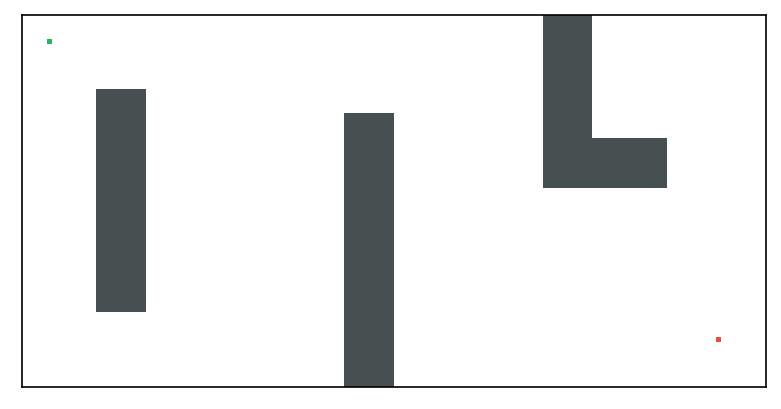

In [2]:
height = 15
width = 30
map_str = '''
. . . . . . . . . . . . . . . . . . . . . @ @ . . . . . . .  
. . . . . . . . . . . . . . . . . . . . . @ @ . . . . . . . 
. . . . . . . . . . . . . . . . . . . . . @ @ . . . . . . . 
. . . @ @ . . . . . . . . . . . . . . . . @ @ . . . . . . . 
. . . @ @ . . . . . . . . @ @ . . . . . . @ @ . . . . . . . 
. . . @ @ . . . . . . . . @ @ . . . . . . @ @ @ @ @ . . . . 
. . . @ @ . . . . . . . . @ @ . . . . . . @ @ @ @ @ . . . . 
. . . @ @ . . . . . . . . @ @ . . . . . . . . . . . . . . . 
. . . @ @ . . . . . . . . @ @ . . . . . . . . . . . . . . . 
. . . @ @ . . . . . . . . @ @ . . . . . . . . . . . . . . . 
. . . @ @ . . . . . . . . @ @ . . . . . . . . . . . . . . . 
. . . @ @ . . . . . . . . @ @ . . . . . . . . . . . . . . . 
. . . . . . . . . . . . . @ @ . . . . . . . . . . . . . . . 
. . . . . . . . . . . . . @ @ . . . . . . . . . . . . . . .
. . . . . . . . . . . . . @ @ . . . . . . . . . . . . . . .
'''

test_map = Map()
test_map.read_from_string(map_str, width, height)
start = Node(1, 1)
goal = Node(13, 28)
draw(test_map, start, goal)

Path found! Length: 26.18033988749895. Nodes created: 630. Number of steps: 198. Correct: False. Runtime: 0.04004693031311035ms.


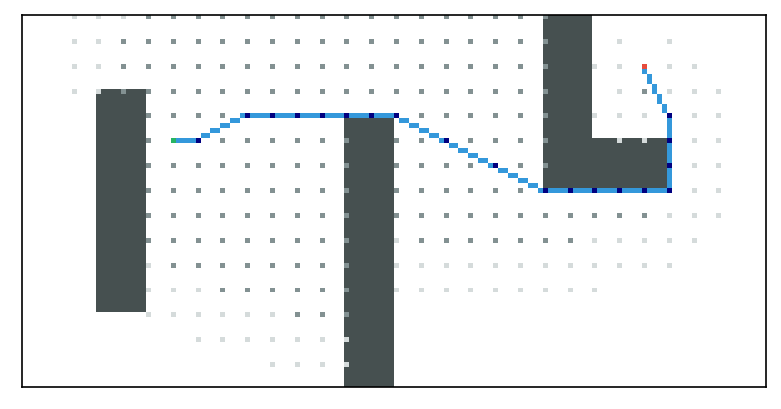

In [3]:
k = 4
stats = simple_test(Map_2k(k), astar, 6, h_2k, SearchTreePQS, k=k)

Path found! Length: 26.18033988749895. Nodes created: 236. Number of steps: 198. Correct: False. Runtime: 0.007001638412475586ms.


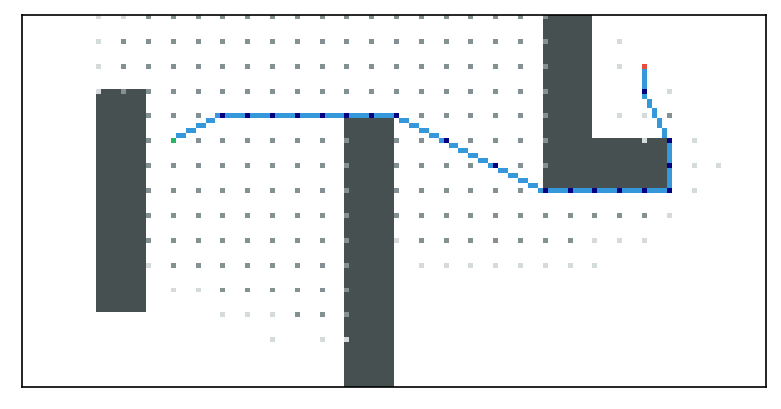

Path is canonical: False


In [4]:
k = 4
stats = simple_test(Map_2k(k), canonical_astar, 6, h_2k, SearchTreePQS, k=k)
print("Path is canonical:", path_is_canonical(test_map, stats[1]))

Path found! Length: 25.941549404533223. Nodes created: 12533. Number of steps: 197. Correct: False. Runtime: 1.276949405670166ms.


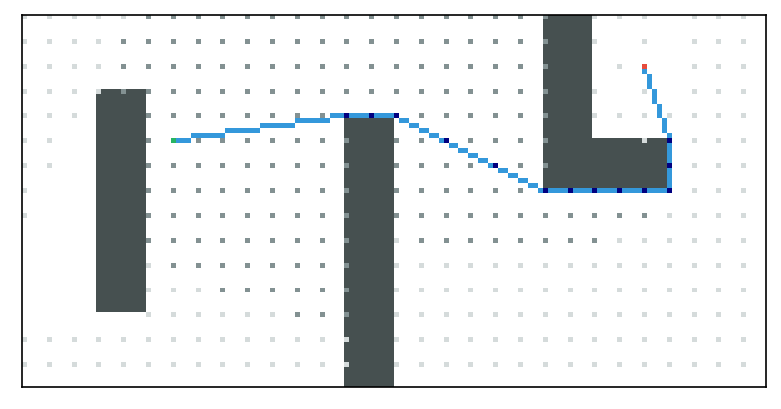

In [5]:
stats = simple_test(MapFullGraph(), full_graph_astar, 6, euclidian_distance, SearchTreePQS)